Gaussian Process Regression and Statistic Process Control -- Timeseries Data Anomaly Detection as an Example

Author: Shuaiwen Cui

Email: SHUAIWEN001@e.ntu.edu.sg

Reference:

[1] https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP 

[2] https://zhuanlan.zhihu.com/p/104601803

[3] https://scikit-learn.org/stable/modules/gaussian_process.html

Outline:

I - Data Preparation

II - Gaussian Process Regression

III - Statistic Process Control for Anolmaly Data Detection


In [56]:
# import libraries
import math

import numpy as np

import scipy
from scipy.io import loadmat  # for loading matlab files

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import GridSearchCV


I - Data Preparation

In [57]:
# training data loading - input and output

x_train = loadmat('x_train.mat')
x_train = np.array(x_train['x_train'])
# x_train = np.reshape(x_train[:,1],(-1,1)) # only the second column is used as input for simplicity
print(type(x_train),x_train.shape)

y_train = loadmat('y_train.mat')
y_train = np.array(y_train['y_train'])
# y_train = np.reshape(y_train[:,0],(-1,1))
print(type(y_train),y_train.shape)

<class 'numpy.ndarray'> (215, 2)
<class 'numpy.ndarray'> (215, 1)


In [58]:
# test data loading - input and ground truth output, predicted output is to be generated by GPR model

x_test = loadmat('x_test.mat')
x_test = np.array(x_test['x_test'])
# x_test = np.reshape(x_test[:,1],(-1,1)) # only the second column is extracted for simplicity
print(type(x_test),x_test.shape)

y_testtrue = loadmat('y_testtrue.mat')
y_testtrue = np.array(y_testtrue['y'])
# y_testtrue = np.reshape(y_testtrue[:,0],(-1,1))
print(type(y_testtrue),y_testtrue.shape)

<class 'numpy.ndarray'> (147, 2)
<class 'numpy.ndarray'> (147, 1)


In [59]:
# truncate data for limited resources
OFFSET = 0
NUM_TRAIN = 20
NUM_PRED = 10

# take the first NUM_TRAIN samples for training
x_train = x_train[OFFSET:NUM_TRAIN + OFFSET]
y_train = y_train[OFFSET:NUM_TRAIN + OFFSET]

# print the size of the training data
print('x_train size:',x_train.shape)
print('y_train size:',y_train.shape)

# take the first NUM_PRED samples for prediction
x_test = x_test[:NUM_PRED]
y_testtrue = y_testtrue[:NUM_PRED]

# print the size of the test data
print('x_test size:',x_test.shape)
print('y_testtrue size:',y_testtrue.shape)

x_train size: (20, 2)
y_train size: (20, 1)
x_test size: (10, 2)
y_testtrue size: (10, 1)


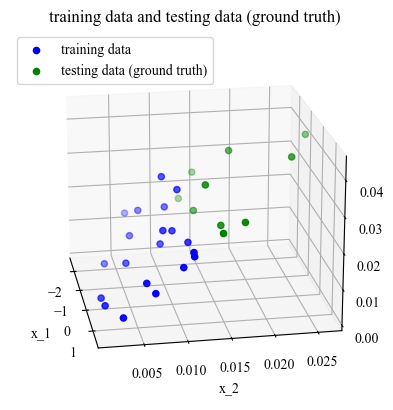

In [60]:
# check the data for training and testing

fig_dc = plt.figure()
ax_dc = fig_dc.add_subplot(111, projection = '3d')

# plot the data
ax_dc.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'blue',label = 'training data')
ax_dc.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'green',label = 'testing data (ground truth)')

# set the limits for the plots
# ax_dc.set_xlim(-5, 5)
# ax_dc.set_ylim(0, 0.05)
# ax_dc.set_zlim(0, 0.1)

# set the labels and titles for the plots
ax_dc.set_xlabel('x_1')
ax_dc.set_ylabel('x_2')
ax_dc.set_zlabel('y')
ax_dc.set_title('training data and testing data (ground truth)')

# add legends for the plots
plt.legend(loc = 'upper left')

# view
ax_dc.view_init(20, -10)

# Show the plot
plt.show()

II - Gaussian Process Regression

for the kernel, we adopt ARD square exponential kernel. refer to reference 3

ARD allows us to place different weight on input. For instance, for the two columns input data, ARD allow us to place different importance on these two columns.


In [61]:
# KernelConst = 0.0156 # kernel constant for constant kernel
# LengthScale = [100,100] # length scale for RBF kernel, 2D input, different weights for different dimensions
# alpha = 0.05 # noise level

KernelConst = 1 # kernel constant for constant kernel
LengthScale = [5,0.2] # length scale for RBF kernel, 2D input, different weights for different dimensions
alpha = 0.0004 # noise level

In [62]:
# define the kernel
# kernel = ConstantKernel(sigmaM0) * RBF(sigmaF0)
kernel = ConstantKernel(KernelConst) * RBF(length_scale = LengthScale,length_scale_bounds = (1e-3, 1e3))

# define the model using the defined kernel
gprMdl = GaussianProcessRegressor(kernel = kernel, alpha = alpha, normalize_y = True)

# Fit the model with the training data
gprMdl.fit(x_train, y_train)


C:\Users\cswof\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.0004, kernel=1**2 * RBF(length_scale=[5, 0.2]),
                         normalize_y=True)

In [63]:
# Predict the output for the test data
y_testpred, y_teststd = gprMdl.predict(x_test, return_std = True) 
yint = gprMdl.predict(x_test, return_std = False, return_cov = False) 
print('gpr model fitted!')

# reshape the data
y_testpred = np.reshape(y_testpred, (-1, 1))
y_teststd = np.reshape(y_teststd, (-1, 1))
y_testint = np.reshape(yint, (-1, 1))

print(y_testpred.shape)  # Print the predicted output

print(gprMdl.score(x_test,y_testtrue))  # Print the kernel parameters

gpr model fitted!
(10, 1)
-6.758386770936057


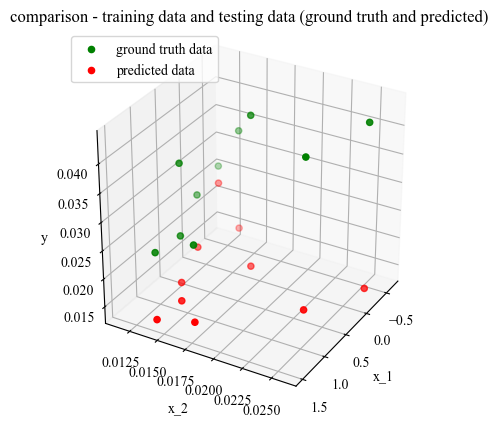

In [64]:
# check generated data for testing
fig_gpr = plt.figure()
ax_gpr = fig_gpr.add_subplot(111, projection='3d')
# ax_gpr.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'blue',label = 'training data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'green',label = 'ground truth data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred, c = 'red',label = 'predicted data')

# # set the limits for the plots
# ax_gpr.set_xlim(-5, 5)
# ax_gpr.set_ylim(0, 0.05)
# ax_gpr.set_zlim(0, 0.05)

# set the labels and titles for the plots
ax_gpr.set_xlabel('x_1')
ax_gpr.set_ylabel('x_2')
ax_gpr.set_zlabel('y')
ax_gpr.set_title('comparison - training data and testing data (ground truth and predicted)')

# add legends for the plots
plt.legend(loc = 'upper left')

# view
ax_gpr.view_init(30, 30)
# ax_gpr.view_init(90, 0)

# perspective mode setup
ax_gpr.set_box_aspect([1,1,1])

# Show the plot
plt.show()

# print(max(y_testpred))

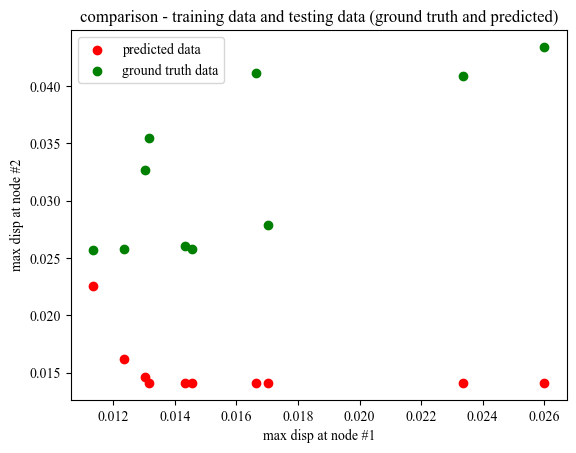

In [65]:
# 2D analysis - recall that the physical meaning is to use one pier max disp to predict the other

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# ax_gpr2d.scatter(x_train[:,1], y_train, c = 'blue',label = 'training data')
ax_gpr2d.scatter(x_test[:,1], y_testpred, c = 'red',label = 'predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c = 'green',label = 'ground truth data')

# set the labels and titles for the plots
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted)')

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()

Grid Search for Parameters Optimization

In [66]:
# grid research for kernel parameters
# from sklearn.model_selection import GridSearchCV

# param_grid = {'kernel': [ConstantKernel(KernelConst) * RBF(LengthScale) for KernelConst in [0.01, 0.1, 1, 10] for LengthScale in [0.01, 0.1, 1, 10]],alpha: [0.01, 0.05, 0.1, 1, 10, 100]}
param_grid = {'kernel': [( ConstantKernel(KernelConst) * RBF(LengthScale))
                         for KernelConst in [1]
                         for LengthScale in [ (5, 0.2)]],
              'alpha': [0.004]}
model = GaussianProcessRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5) # cv is the number of folds for cross validation
grid_search.fit(x_train, y_train)  # X is your input data, y is your target variable

GPR_Params = grid_search.best_params_
GPR_Model= grid_search.best_estimator_

print(GPR_Params)

{'alpha': 0.004, 'kernel': 1**2 * RBF(length_scale=[5, 0.2])}


C:\Users\cswof\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\cswof\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\cswof\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\cswof\AppData\Ro

In [67]:
print(GPR_Params)
print(GPR_Model.score(x_test,y_testtrue))  # Print the kernel parameters

{'alpha': 0.004, 'kernel': 1**2 * RBF(length_scale=[5, 0.2])}
-21.403330307887405


In [68]:
# train the model with the best parameters
GPR_Model.fit(x_train, y_train)

# Predict the output for the test data
y_testpred, sigma = GPR_Model.predict(x_test, return_std=True) # y_pred is the predicted output, sigma is the standard deviation

# 95.45% confidence interval - 2 sigma
y_testpred_lb = y_testpred - 2 * sigma # lower bound of the confidence interval
y_testpred_ub = y_testpred + 2 * sigma # upper bound of the confidence interval

# reshape the data
y_testpred = np.reshape(y_testpred, (-1, 1))
y_testpred_lb = np.reshape(y_testpred_lb, (-1, 1))
y_testpred_ub = np.reshape(y_testpred_ub, (-1, 1))


C:\Users\cswof\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


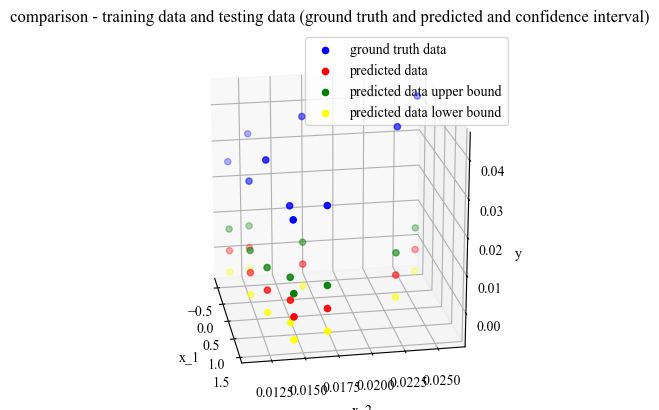

In [69]:
# visualize the data and confidence interval - 3D

# check generated data for testing
fig_gpr = plt.figure()
ax_gpr = fig_gpr.add_subplot(111, projection='3d')
# ax_gpr.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'black',label = 'training data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'blue',label = 'ground truth data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred, c = 'red',label = 'predicted data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred_ub, c = 'green',label = 'predicted data upper bound')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred_lb, c = 'yellow',label = 'predicted data lower bound')


# # set the limits for the plots
# ax_gpr.set_xlim(-5, 5)
# ax_gpr.set_ylim(0, 0.05)
# ax_gpr.set_zlim(0, 0.05)

# set the labels and titles for the plots
ax_gpr.set_xlabel('x_1')
ax_gpr.set_ylabel('x_2')
ax_gpr.set_zlabel('y')
ax_gpr.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# view
# ax_gpr.view_init(30, 30)
ax_gpr.view_init(20, -10)

# perspective mode setup
ax_gpr.set_box_aspect([1,1,1])

# Show the plot
plt.show()

# print(max(y_testpred))

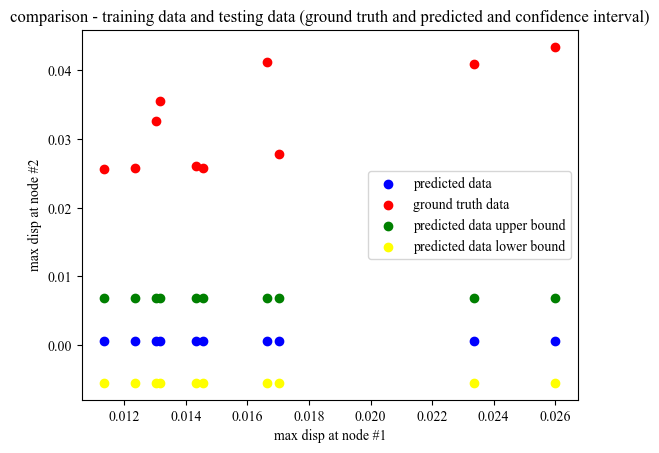

In [70]:
# 2D analysis - recall that the physical meaning is to use one pier max disp to predict the other

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# ax_gpr2d.scatter(x_train[:,1], y_train, c = 'black',label = 'training data')
ax_gpr2d.scatter(x_test[:,1], y_testpred, c = 'blue',label = 'predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c = 'red',label = 'ground truth data')
ax_gpr2d.scatter(x_test[:,1], y_testpred_ub, c = 'green',label = 'predicted data upper bound')
ax_gpr2d.scatter(x_test[:,1], y_testpred_lb, c = 'yellow',label = 'predicted data lower bound')

# # fill the confidence interval
# fill_x = np.concatenate([x_test[:,1], x_test[:,1]],axis = 0)
# fill_y = np.concatenate([y_testpred_ub[:,0], y_testpred_lb[:,0]],axis = 0)
# fill_x, fill_y = zip(*sorted(zip(fill_x, fill_y)))
# tri = Delaunay(np.array([fill_x, fill_y]).T)
# plt.triplot(fill_x, fill_y, tri.simplices, color='blue', alpha=0.2)
# plt.fill(fill_x, fill_y, color='purple', alpha=0.2)

# set the labels and titles for the plots
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()




note the function of noise - alpha!!!

III - Statistic Process Control

upper limit:  [0.04275378]
lower limit:  0.006172314861394543


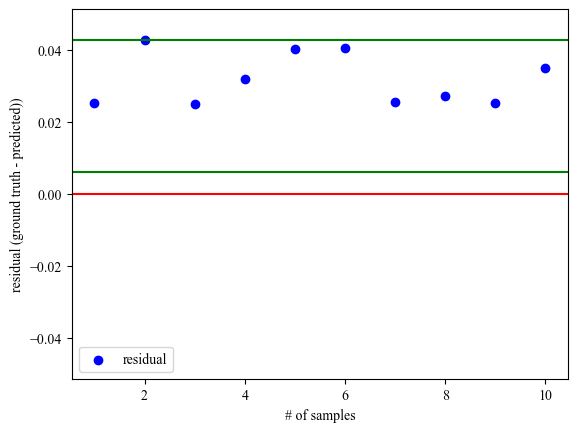

In [71]:
# calculate the residual
y_res = y_testtrue - y_testpred

# visualize the residual - 2D
fig_spc2d = plt.figure()
ax_spc2d = fig_spc2d.add_subplot(111)

SampleNumber = np.linspace(1,len(y_res),len(y_res))

ax_spc2d.scatter(SampleNumber, y_res, c = 'blue',label = 'residual')

# set the labels and titles for the plots
ax_spc2d.set_xlabel('# of samples')
ax_spc2d.set_ylabel('residual (ground truth - predicted))')

# set the limits for the plots

# xmin_res = min(x_test[:,1])
# xmax_res = max(x_test[:,1])
ymin_res = min(y_res)
ymax_res = max(y_res)
ymark = max(abs(ymin_res), abs(ymax_res))

# ax_spc2d.set_xlim(-1.1*xmin_res, 1.1*xmax_res)
ax_spc2d.set_ylim(-1.2*ymark, 1.2*ymark)

# 0 line
plt.axhline(0, color='red')  # Draw the line at y = 0

# control limit
upper_limit = max(2 * np.mean(sigma),max(y_res))
lower_limit = min(2 * np.mean(sigma),min(y_res))
plt.axhline(upper_limit, color='green') # Draw the line at y = upper_limit
plt.axhline(lower_limit, color='green') # Draw the line at y = lower_limit

print('upper limit: ', upper_limit)
print('lower limit: ', lower_limit)

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()


